In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import glob

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
IMG_WID, IMG_HG = 256, 256
IMG_SIZE = (IMG_WID, IMG_HG)

In [3]:
data_images = '/kaggle/input/project-images/Data/Sport Images'
data_video = '/kaggle/input/project-images/Data/Sport Videos'

# Creating the required dataset

In [4]:
def split_folders(image_path, label_count):
    dataset = tf.keras.utils.image_dataset_from_directory(image_path,labels=None,label_mode='int',color_mode='rgb',batch_size=None,image_size=IMG_SIZE,seed=20)
    dataset = dataset.map(lambda x: (x, label_count))
    total_file = len(dataset)
    train_size, val_size = int(np.ceil(total_file*0.7)), int(np.ceil(total_file*0.15))
    test_size = total_file - (train_size + val_size)
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size + val_size).take(test_size)
    return [train, val, test]

In [5]:
classes = ['baseball','basketball','fencing','tennis','volleyball']
data_sets = []
for idx in range(len(classes)):
    data_sets.append(split_folders(data_images+'/'+classes[idx], idx))

Found 734 files belonging to 1 classes.
Found 492 files belonging to 1 classes.
Found 634 files belonging to 1 classes.
Found 715 files belonging to 1 classes.
Found 704 files belonging to 1 classes.


In [6]:
train, val, test = data_sets[0][0],data_sets[0][1],data_sets[0][2]
for t, v, tst in data_sets[1:]:
    train = train.concatenate(t)
    val = val.concatenate(v)
    test = test.concatenate(tst)

# Data Augmentation

In [7]:
image_augmentation_flip = tf.keras.layers.RandomFlip("horizontal_and_vertical")
image_augmentation_rotation = tf.keras.layers.RandomRotation((-0.1, 0.3))
image_augmentation_translation = tf.keras.layers.RandomTranslation((-0.1, 0.5), (-0.2, 0.4))
image_augmentation_zoom = tf.keras.layers.RandomZoom((-0.1, 0.4))
image_augmentation_brightness = tf.keras.layers.RandomBrightness(0.6)
image_augmentation_contrast = tf.keras.layers.RandomContrast(0.3)

In [8]:
def chooseRandom(img):
    choice = [0,1]
    np.random.shuffle(choice)
    if choice == 1:
        return image_augmentation_zoom(image_augmentation_rotation(image_augmentation_brightness(image_augmentation_translation(img))))
    else:
        return image_augmentation_contrast(image_augmentation_flip(img))

In [9]:
dataset_random_augmentation = train.map(lambda i,l:(chooseRandom(i), l))
dataset_flip = train.map(lambda i,l:(image_augmentation_flip(i), l))
dataset_rotated = train.map(lambda i,l:(image_augmentation_rotation(i), l))
dataset_bright = train.map(lambda i,l:(image_augmentation_brightness(i), l))
dataset_zoomed = train.map(lambda i,l:(image_augmentation_zoom(i), l))

In [10]:
augmented_train = train.concatenate(dataset_random_augmentation)
augmented_train = augmented_train.concatenate(dataset_flip)
augmented_train = augmented_train.concatenate(dataset_rotated)
augmented_train = augmented_train.concatenate(dataset_bright)
augmented_train = augmented_train.concatenate(dataset_zoomed)

In [11]:
augmented_train = augmented_train.batch(128, drop_remainder=True)
validation = val.batch(128, drop_remainder=True)
test_dataset = test.batch(128, drop_remainder=True)

# Model Creation

In [12]:
def modelCreation(base):
    for layer in base.layers:
        layer.trainable = False
    model = tf.keras.layers.Flatten()(base.output)
    model = tf.keras.layers.Dense(32, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.2)(model)
    model = tf.keras.layers.BatchNormalization()(model)
    model_prediction = tf.keras.layers.Dense(5, activation = 'softmax')(model)
    model_final = tf.keras.Model(inputs = base.input, outputs = model_prediction)
    model_final.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model_final

In [13]:
resnet = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
efficient = tf.keras.applications.EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))
vgg = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (IMG_WID, IMG_HG, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
resnet_model = modelCreation(resnet)
efficient_model = modelCreation(efficient)
vgg_model = modelCreation(vgg)

In [15]:
# Early stop and restore weight from best model, min validation loss
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

In [16]:
resnet_history = resnet_model.fit(augmented_train, epochs=50, batch_size=128, callbacks=[early_stopper], verbose=1, validation_data=validation)

Epoch 1/50
107/107 [==============================] - 112s 944ms/step - loss: 1.7205 - accuracy: 0.2258 - val_loss: 1.6154 - val_accuracy: 0.4766
Epoch 2/50
107/107 [==============================] - 93s 860ms/step - loss: 1.6355 - accuracy: 0.2579 - val_loss: 1.3521 - val_accuracy: 0.7344
Epoch 3/50
107/107 [==============================] - 94s 872ms/step - loss: 1.6125 - accuracy: 0.2817 - val_loss: 1.3075 - val_accuracy: 0.8203
Epoch 4/50
107/107 [==============================] - 92s 854ms/step - loss: 1.5975 - accuracy: 0.2955 - val_loss: 1.1848 - val_accuracy: 0.9036
Epoch 5/50
107/107 [==============================] - 97s 899ms/step - loss: 1.5917 - accuracy: 0.3029 - val_loss: 1.3843 - val_accuracy: 0.8333
Epoch 6/50
107/107 [==============================] - 93s 862ms/step - loss: 1.5849 - accuracy: 0.3175 - val_loss: 1.4176 - val_accuracy: 0.8802
Epoch 7/50
107/107 [==============================] - 92s 856ms/step - loss: 1.5815 - accuracy: 0.3235 - val_loss: 1.1507 - val_a

In [17]:
efficient_history = efficient_model.fit(augmented_train, epochs=50, batch_size=128, callbacks=[early_stopper], verbose=1, validation_data=validation)

Epoch 1/50


2023-05-08 13:30:33.973064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


107/107 [==============================] - 94s 813ms/step - loss: 1.8163 - accuracy: 0.2475 - val_loss: 0.9356 - val_accuracy: 0.8177
Epoch 2/50
107/107 [==============================] - 87s 806ms/step - loss: 1.6752 - accuracy: 0.2894 - val_loss: 0.9053 - val_accuracy: 0.9062
Epoch 3/50
107/107 [==============================] - 86s 796ms/step - loss: 1.6306 - accuracy: 0.3148 - val_loss: 0.9067 - val_accuracy: 0.9792
Epoch 4/50
107/107 [==============================] - 87s 802ms/step - loss: 1.6047 - accuracy: 0.3300 - val_loss: 0.9271 - val_accuracy: 0.9557
Epoch 5/50
107/107 [==============================] - 91s 847ms/step - loss: 1.5877 - accuracy: 0.3405 - val_loss: 0.8834 - val_accuracy: 0.9688
Epoch 6/50
107/107 [==============================] - 86s 795ms/step - loss: 1.5766 - accuracy: 0.3552 - val_loss: 0.8899 - val_accuracy: 0.9766
Epoch 7/50
107/107 [==============================] - 87s 804ms/step - loss: 1.5704 - accuracy: 0.3629 - val_loss: 0.8639 - val_accuracy: 0.9

In [18]:
vgg_history = vgg_model.fit(augmented_train, epochs=50, batch_size=128, callbacks=[early_stopper], verbose=1, validation_data=validation)

Epoch 1/50
107/107 [==============================] - 108s 906ms/step - loss: 1.8159 - accuracy: 0.2162 - val_loss: 1.4206 - val_accuracy: 0.6432
Epoch 2/50
107/107 [==============================] - 102s 947ms/step - loss: 1.6719 - accuracy: 0.2451 - val_loss: 1.3567 - val_accuracy: 0.7135
Epoch 3/50
107/107 [==============================] - 98s 907ms/step - loss: 1.6342 - accuracy: 0.2650 - val_loss: 1.1267 - val_accuracy: 0.8047
Epoch 4/50
107/107 [==============================] - 98s 902ms/step - loss: 1.6148 - accuracy: 0.2766 - val_loss: 1.1045 - val_accuracy: 0.8385
Epoch 5/50
107/107 [==============================] - 104s 960ms/step - loss: 1.5999 - accuracy: 0.2878 - val_loss: 1.1636 - val_accuracy: 0.8594
Epoch 6/50
107/107 [==============================] - 98s 905ms/step - loss: 1.5897 - accuracy: 0.2992 - val_loss: 1.0708 - val_accuracy: 0.8490
Epoch 7/50
107/107 [==============================] - 97s 900ms/step - loss: 1.5835 - accuracy: 0.3072 - val_loss: 1.0319 - val

#### Loss VS Epoch 

In [19]:
def plotLossVSEpoch(model_history, model):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('{} Loss vs Epoch'.format(model))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

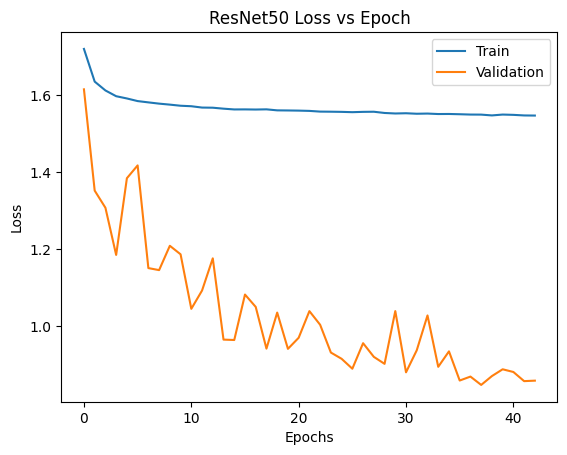

In [20]:
plotLossVSEpoch(resnet_history, 'ResNet50')

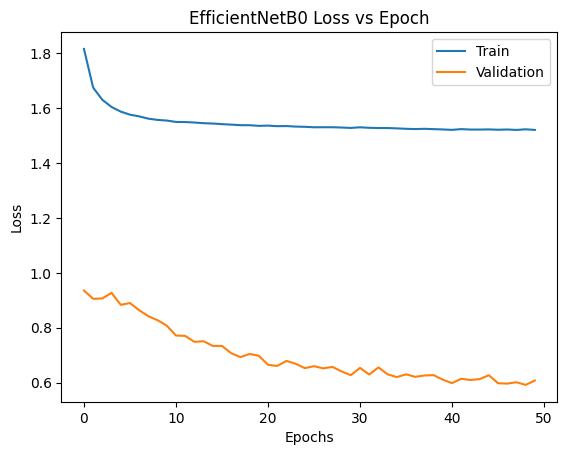

In [21]:
plotLossVSEpoch(efficient_history, 'EfficientNetB0')

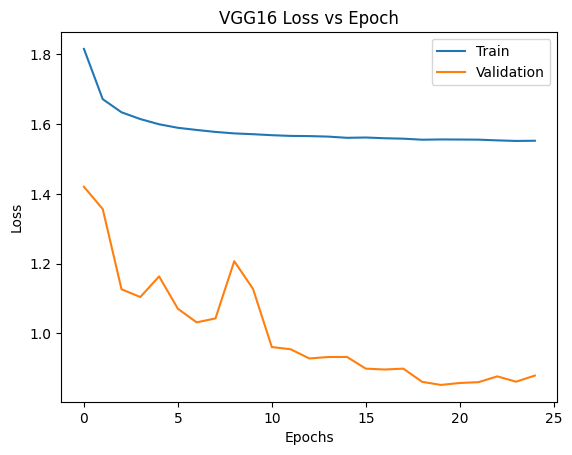

In [22]:
plotLossVSEpoch(vgg_history, 'VGG16')

### Getting the Predictions

#### Train

In [23]:
train_resnet_probabilities = resnet_model.predict(augmented_train)
train_efficient_probabilities = efficient_model.predict(augmented_train)
train_vgg_probabilities = vgg_model.predict(augmented_train)

# Pick class with highest probabilty
train_resnet_prediction = np.argmax(train_resnet_probabilities, axis=1)
train_efficient_prediction = np.argmax(train_efficient_probabilities, axis=1)
train_vgg_prediction = np.argmax(train_vgg_probabilities, axis=1)

107/107 [==============================] - 93s 869ms/step


#### Test

In [24]:
test_resnet_probabilities = resnet_model.predict(test_dataset)
test_efficient_probabilities = efficient_model.predict(test_dataset)
test_vgg_probabilities = vgg_model.predict(test_dataset)

# Pick class with highest probabilty
test_resnet_prediction = np.argmax(test_resnet_probabilities, axis=1)
test_efficient_prediction = np.argmax(test_efficient_probabilities, axis=1)
test_vgg_prediction = np.argmax(test_vgg_probabilities, axis=1)

3/3 [==============================] - 6s 2s/step


### Analysis of Image Models

In [25]:
def findaccuracy(y_true, y_pred):
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == yp:            
            correct_predictions += 1
    return correct_predictions / len(y_true)

In [26]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):
    tp = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 1 and yp == 1:
            tp += 1
    return tp

def true_negative(y_true, y_pred):    
    tn = 0
    for yt, yp in zip(y_true, y_pred):        
        if yt == 0 and yp == 0:
            tn += 1
    return tn

def false_positive(y_true, y_pred):    
    fp = 0
    for yt, yp in zip(y_true, y_pred):
        if yt == 0 and yp == 1:
            fp += 1            
    return fp

def false_negative(y_true, y_pred):
    fn = 0    
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 0:
            fn += 1            
    return fn
#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize precision to 0
    precision = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
    # calculate and return average precision over all classes
    precision /= num_classes
    return precision

In [27]:
def macro_recall(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize recall to 0
    recall = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # keep adding recall for all classes
        recall += temp_recall
    # calculate and return average recall over all classes
    recall /= num_classes
    return recall

In [28]:
def macro_f1(y_true, y_pred):
    # find the number of classes
    num_classes = len(np.unique(y_true))
    # initialize f1 to 0
    f1 = 0
    # loop over all classes
    for class_ in np.unique(y_true):
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        # keep adding f1 score for all classes
        f1 += temp_f1
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    return f1

In [29]:
from sklearn.metrics import confusion_matrix

def printResults(model_name, y_true, y_prediction):
    print("Results for model {}".format(model_name))
    # Calculate the confusion matrix
    cm = confusion_matrix( y_true, y_prediction)
    print("Confusion Matrix:\n", cm)

    precision = macro_precision( y_true, y_prediction)
    recall = macro_recall( y_true, y_prediction)
    accuracy = findaccuracy( y_true, y_prediction)
    f1 = macro_f1( y_true, y_prediction)

    print("Precision:", precision)
    print("Recall:", recall)
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

In [30]:
testing_labels = []
for img, label in (test_dataset.take(len(test_dataset))):
  testing_labels += list(label.numpy())
testing_labels = np.array(testing_labels)

In [31]:
training_labels = []
for img, label in (augmented_train.take(len(augmented_train))):
  training_labels += list(label.numpy())
training_labels = np.array(training_labels)

#### Train 

In [32]:
printResults('ResNet50', training_labels, train_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[3001    7   63   11    2]
 [   0 2057    0    4    9]
 [   3    0 2648    0   13]
 [1238   11   18 1720   19]
 [   1   50   13    2 2806]]
Precision: 0.9232242061433291
Recall: 0.9020018306434938
Accuracy: 0.893107476635514
F1 Score: 0.897145966728783


In [33]:
printResults('EfficientNetB0', training_labels, train_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[3052    0   18   11    3]
 [   0 2068    0    2    0]
 [   0    0 2655    1    8]
 [  43   10    3 2940   10]
 [   0   21    1    2 2848]]
Precision: 0.9900774372102935
Recall: 0.9909933335046738
Accuracy: 0.9902891355140186
F1 Score: 0.9905095516871224


In [34]:
printResults('VGG16', training_labels, train_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[2909    7   78   62   28]
 [   2 2028    0    8   32]
 [  11    0 2584    0   69]
 [ 932   35   50 1900   89]
 [   4   52   18    1 2797]]
Precision: 0.9095824947108981
Recall: 0.8997781228683731
Accuracy: 0.8920852803738317
F1 Score: 0.8954969708505944


### Test

In [35]:
printResults('ResNet50', testing_labels, test_resnet_prediction)

Results for model ResNet50
Confusion Matrix:
 [[108   0   0   0   1]
 [  0  73   0   0   0]
 [  0   0  94   0   0]
 [ 34   0   0  72   0]
 [  0   0   0   0   2]]
Precision: 0.8854459562288625
Recall: 0.9340140862514932
Accuracy: 0.9088541666666666
F1 Score: 0.8939087439144714


In [36]:
printResults('EfficientNetB0', testing_labels, test_efficient_prediction)

Results for model EfficientNetB0
Confusion Matrix:
 [[109   0   0   0   0]
 [  0  73   0   0   0]
 [  0   0  94   0   0]
 [  2   0   0 104   0]
 [  0   0   0   0   2]]
Precision: 0.996396287836647
Recall: 0.9962263065409491
Accuracy: 0.9947916666666666
F1 Score: 0.9962764477390322


In [37]:
printResults('VGG16', testing_labels, test_vgg_prediction)

Results for model VGG16
Confusion Matrix:
 [[109   0   0   0   0]
 [  0  73   0   0   0]
 [  0   0  93   0   1]
 [ 42   0   0  63   1]
 [  0   0   0   0   2]]
Precision: 0.8443708269061935
Recall: 0.9167401571528749
Accuracy: 0.8854166666666666
F1 Score: 0.8490680161757957


### Video Analysis

### References

1. https://pillow.readthedocs.io/en/stable/reference/Image.html#module-PIL.Image

2. https://pillow.readthedocs.io/en/stable/reference/Image.html

3. https://www.geeksforgeeks.org/python-pil-image-resize-method/

4. https://www.geeksforgeeks.org/convert-an-image-into-jpg-format-using-pillow-in-python/

5. https://medium.com/@ajeet214/image-type-conversion-jpg-png-jpg-webp-png-webp-with-python-7d5df09394c9